### Get Pelvis data - LPF + Norm (save Figure + csv)
### Get oneHot encoded Label 
### Interpolation (Univariate Interpolation)

In [1]:
import os
import numpy as np 
import time
from sklearn.model_selection import KFold  # 라벨 x_data, y_data 분포를 유지 (함께 fold)
from IPython.display import clear_output

homeDir = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel"
os.chdir(homeDir); print(" [Home Dir.] Current path", os.getcwd())  

from TCN_v1_Lib.preprocessing import preprocess
from TCN_v1_Lib.plot_graph import plotGragh

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현

 [Home Dir.] Current path /DockerProjects/walkCAM/tug/temporalCNN_wLabel


In [2]:
rootDir = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel" 
expertFolder = "/" + "HMM_saveResults_illness_mean"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 

utils = preprocess(datasetDir, expertFolder)
plot = plotGragh(actSplit=True, save=False)

 Current workaing path [dataset]  /DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/HMM_saveResults_illness_mean/0_sideView


In [3]:
#---- Param Selection-----#
# lpf_order = 4
# cut_off = 0.5
# selected_LPF = "c{0}o{1}".format(cut_off,lpf_order).replace(".","-")
# print(" --------- Seleced Type: LPF (4th) Cutoff ",cut_off,"Hz")

# selected_type = 'norm20' # stroke -3 ,  norm60 -22,  norm20 -1
# mean_datalist = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/{selected_LPF}/{selected_LPF}_mean_{selected_type}.csv".format(selected_LPF=selected_LPF, selected_type=selected_type)
# print("selected_type: ", selected_type, "\n --> File Path: ", mean_datalist )

illtyeps = ["norm20", "norm60"] # next(os.walk(datasetDir))[1]  # 

lpf_order = 4
freqs = [0.3] #[0.5, 3.5]
selected_LPF = None
selected_type = 'norm60' # stroke -3 ,  norm60 -22,  norm20 -1

save = True

class_weight_1 = {0:0.303, 1:1.0, 2: 0.144, 3:0.487, 4: 0.7} #
class_weight_2 = {0:1.3 , 1:4.5, 2: 1.0 ,  3: 1.6, 4: 4.5} # 
class_weight_3 = {0:0.112 , 1:0.365, 2: 0.046 ,  3: 0.184, 4: 0.293} # sum = 1  
class_weight = class_weight_1

cw_type = None

if class_weight == class_weight_1:
    cw_type = "class_weight_1"
elif class_weight == class_weight_2:
    cw_type = "class_weight_2"
elif class_weight == class_weight_3:
    cw_type = "class_weight_3"

#--------------------- 
batch_size = 512
epochs = 100000

learning_rate = 0.00007 #0.0001
patience = 50

### Train/Test Subject Split

In [4]:
def fold_trainNames(subList, Kfold_num = 5):
    assert (Kfold_num is not 0), print("check kfold_num. should not be zero")
    Fold_results =[]
    kfold = KFold(n_splits=  Kfold_num)
    
    for trainIdx, testIdx in kfold.split(subList):
        Fold_results.append([trainIdx, testIdx])      
        
    train_Fold= []
    test_Fold = []
        
    for i in range(Kfold_num):    # bind fold pair
        tmp_train = []
        tmp_test = []
        for subIdx in range(len(subList)): 
            if subIdx in Fold_results[i][0]:  # -- K-fold train
                tmp_train.append(subList[subIdx])
               
            if subIdx in Fold_results[i][1]:  # -- K-fold test
                tmp_test.append(subList[subIdx])
          
        train_Fold.append(tmp_train)
        test_Fold.append(tmp_test)
        print("\t [process]", i, "-fold:", train_Fold[i], "\n\t\t\t   ,", test_Fold[i])
    print("\n [results]  trainSet: ", len(train_Fold[0]) , " 명 , testSet: ", len(test_Fold[0]), " 명" )
    
    return train_Fold, test_Fold


In [5]:
from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tcn import TCN
import tensorflow as tf



 #Residual block :: https://roadcom.tistory.com/95
def ResBlock(x,filters,kernel_size,dilation_rate):
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate,activation='relu')(x) #first convolution
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate)(r) #Second convolution
    if x.shape[-1]==filters:
        # Shortcut 의 channel 과 main path 의 channel 이 일치할 경우 단순 add 연산만 진행하는 블록 = identity block
        shortcut = x  # identity block 
    else: 
        # Shortcut 의 channel 과 main path 의 channel 이 다를 경우 shortcut path 를 적절히 변환
        # 즉, projection 을 통해 channel 을 맞춰주는 작업이(projection shortcut) 추가되기에 이를 convolution block 이라함
        shortcut=Conv2D(filters,kernel_size=kernel_size,padding='same')(x) 
    o=add([r,shortcut])
    o=Activation('relu')(o) 
    return o
 
 #Sequence Model
def TCN(optimizer='adam'):
    kernel_size = (3,3)
    input_shape =  (utils.lookback_window, 3, 1) # (8,3, 1) = (feature, sliding_window, 1)
    
    inputs=Input(shape=input_shape)
    
    x=ResBlock(x = inputs,filters=32,kernel_size=kernel_size,dilation_rate=1)
    x = Dropout(0.2) (x)
    x=ResBlock(x,filters=32,kernel_size=kernel_size,dilation_rate=2)
    x = Dropout(0.4)(x)
    x=ResBlock(x,filters=16,kernel_size=kernel_size,dilation_rate=4)
    
    x=Flatten()(x)
    x=Dense(utils.numActions, activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
         
    model.summary()
        
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     
    return model


def action_frames(y_pred_argmax, ratio_display = False):
    action_label =  {"sit": 0, "sit-stand": 1,  "walk": 2, "turn": 3,  "stand-sit": 4}
    action_cnt =  {"total_frames": 0,"sit": 0, "sit-stand": 0,  "walk": 0, "turn": 0,"stand-sit": 0}

    for i in range(len(y_pred_argmax)):
        action_cnt["total_frames"] +=1
        if y_pred_argmax[i] == action_label["sit"]:
            action_cnt["sit"] +=1
            
        elif y_pred_argmax[i] == action_label["sit-stand"]:
            action_cnt["sit-stand"] +=1
            
        elif y_pred_argmax[i] == action_label["walk"]:
            action_cnt["walk"] +=1
            
        elif y_pred_argmax[i] == action_label["turn"]:
            action_cnt["turn"] +=1
        
            
        elif y_pred_argmax[i] == action_label["stand-sit"]:
            action_cnt["stand-sit"] +=1
        
    if ratio_display:     
        print("[ Action Ratio ]")
        print("\t [ 0 - Sit] ratio of sit: ",  action_cnt["sit"]/action_cnt["total_frames"] )
        print("\t [ 1 - sit-stand] ratio of sit-stand: ",  action_cnt["sit-stand"]/action_cnt["total_frames"])
        print("\t [ 2 - walk] ratio of walk: ",  action_cnt["walk"]/action_cnt["total_frames"])
        print("\t [ 3 - turn] ratio of turn: ",  action_cnt["turn"]/action_cnt["total_frames"])
        print("\t [ 4 - stand-sit] ratio of stand-sit: ",  action_cnt["stand-sit"]/action_cnt["total_frames"])
    return action_cnt
    

In [6]:
from dtw import dtw
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

act_dict = {"sit":0, "sit-to-stand":1, "walk": 2, "turn": 3, "stand-to-sit":4}
answer_y = [act_dict["sit"], act_dict["sit-to-stand"], act_dict["walk"], act_dict["turn"], act_dict["walk"], act_dict["stand-to-sit"], act_dict["sit"] ]
target_names = ["sit", "sit-to-stand", "walk", "turn", "stand-to-sit"]


def post_process_DTW(time_sec, test_y, pred_y, answer_y, title = "normal_20"):
    dtw_index ={"walk":4, "stand-to-sit": 5, "sit": 6}
    dtw_alignment  = dtw(pred_y,answer_y, keep_internals=True)
    
    pred_subTask_sec = np.zeros(5)
    true_subTask_sec = np.zeros(5)
    
    pred_subTask_frame = np.zeros(5, np.uint64)
    true_subTask_frame = np.zeros(5, np.uint64)

    report_time= open(MODEL_SAVE_FOLDER_PATH + "/Report_frameSplit_Results_" + str( title)  +".txt",'w+t')
    # ----------- Time split ... Frame Index
    pred_splitFrame =  np.where( np.abs(dtw_alignment.index2[1:]-dtw_alignment.index2[:-1] ) > 0)[0] 
    true_splitFrame = np.where( np.abs(test_y[1:]-test_y[:-1] ) > 0)[0] + 8 # lookback_window

    print("\npred_splitFrame: {0} \n--> true_splitFrame: {1}".format(pred_splitFrame,true_splitFrame), file = report_time)
    
    for i in range(5):
        pred_subTask_sec[i] = time_sec[ pred_splitFrame[i+1]] - time_sec[ pred_splitFrame[i]]  # sit ~ sit-to-stand (sit-to-stand)
        true_subTask_sec[i] = time_sec[ true_splitFrame[i+1]] - time_sec[ true_splitFrame[i]]     
        
        pred_subTask_frame[i] = pred_splitFrame[i+1] - pred_splitFrame[i]
        true_subTask_frame[i] = true_splitFrame[i+1] - true_splitFrame[i]
    print("\npred subTask frame: {0} \n--> true subTask frame: {1}".format(pred_subTask_frame , true_subTask_frame), file = report_time)
    

  
        
    # ---- Total Time
    pred_totalTime = np.sum(pred_subTask_sec)
    true_totalTime = np.sum(true_subTask_sec)
    print("\nPred SubTask Time: ", pred_subTask_sec, "\t\t Pred Total Time", pred_totalTime, file = report_time)
    print("--> True SubTask Time: ", true_subTask_sec, "\t\t True Total Time", true_totalTime, file = report_time)
 
    #----------- Error---------
    print("\n\n[SubTask Time Error] true - pred (sec): ", np.abs(np.round(true_subTask_sec - pred_subTask_sec,4)), file = report_time)
    print("[Total Time Error] true - pred (sec): " , np.abs(np.round(true_totalTime - pred_totalTime,4)) , file = report_time)
    report_time.close()
    
    # ------------ Index 4,5,6 --> 2,4,0 으로 변경 
    results =[]
    for elements in dtw_alignment.index2:
        if elements == dtw_index["walk"]: 
            elements = act_dict["walk"]
        elif elements == dtw_index["stand-to-sit"]:  
            elements = act_dict["stand-to-sit"]
        elif elements == dtw_index["sit"]:  
            elements =  act_dict["sit"]     
        results.append(elements)


    # 간혹.. dtw 결과가 1개 더 많이 나올 때 있음.. 걍 뒤에 하나 지워버려..
    if len(dtw_alignment.index2) > len(pred_y):
        new_result = results[:-1]
    else:
        new_result = results
        
    return dtw_alignment, new_result, true_subTask_frame, true_totalTime, pred_subTask_frame, pred_totalTime


def plot_postResults(answer_y, pred_y, results, title="dtw"):
    fig = plt.figure(figsize=(18,12))
    
    Gnd_fig = fig.add_subplot(2,3,1)
    Gnd_fig.set_title(" Ground Truth ")
    Gnd_fig.plot(answer_y, "g", label = "Ground Truth")
    plt.legend()
    
    pred_fig = fig.add_subplot(2,3,2)
    pred_fig.set_title(" Prediction Result (Before DTW) ")
    pred_fig.plot(pred_y, "b", label=" pred_y (before DTW)")
    plt.legend()
    
    dtw_fig = fig.add_subplot(2,3,3)
    dtw_fig.set_title(" PostProcessing Results (DTW) ")
    dtw_fig.plot(results, "r",  label="dtw_result")
    plt.legend()
    
    gnd_pred_fig = fig.add_subplot(2,3,4)
    gnd_pred_fig.set_title(" Comparison: Ground Truth vs Prediction")
    gnd_pred_fig.plot(answer_y, "g", label="Ground Truth") # linewidth=3
    gnd_pred_fig.plot(pred_y, "b--", label=" pred_y (before DTW)")
    plt.legend()
    
    pred_dtw_fig = fig.add_subplot(2,3,5)
    pred_dtw_fig.set_title(" Comparison: Prediction vs DTW alignment")
    pred_dtw_fig.plot(pred_y, "b--", label=" pred_y (before DTW)") # linewidth=3
    pred_dtw_fig.plot(results, "r", label=" dtw_result")
    plt.legend()
    
    gnd_dtw_fig = fig.add_subplot(2,3,6)
    gnd_dtw_fig.set_title(" Comparison: Ground Truth vs DTW alignment ")
    gnd_dtw_fig.plot(answer_y, "g--", label="Ground Truth")
    gnd_dtw_fig.plot(results, "r", label="dtw_result")  # linewidth=3
    
    plt.legend()
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/DTW_Comparison_" + title  + ".png")
    
    
    
def create_testdata(pelvis_csv, lookback_window = 8):
    test_x = np.zeros((0, utils.lookback_window,  utils.numPelvis,1 ))
    test_y = np.zeros((0,  utils.numActions)) 
   
    timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  =  utils.getLPF_PelvisData(pelvis_csv)  # raw                 
    pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
    actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
    blockTime, blockPelvis, blockLable =  utils.sliding_window(timstamp_ms, pelvisData, actionData)
    test_x = np.append(test_x, blockPelvis, axis = 0 )
    test_y = np.append(test_y, blockLable, axis = 0 )    

    return blockTime, test_x, test_y


def barplot_splitResults(pred_subTask_frame, true_subTask_frame, pred_totalTime, true_totalTime, title= "normal_20"):
    subTask_label = ['sit-to-stand', 'walk', 'turn', 'walk-back', 'sit-back']
    actIndex = np.arange(len( ["Pred", "Truth"]))
    color = ['b','g','r','c','y']
    
        
    fig = plt.figure(figsize=(12,4))
    plt.title('TUG sub-Task segmentation Results\n', loc='center')
    plt.xlabel('frames')
    plt.yticks(actIndex,  ["Model Pred", "Ground Truth"])
    plt.text(10, 0.5, "True totalTime: " + str(np.round(true_totalTime,4)) + "  ,   Pred totalTime: " + str(np.round(pred_totalTime,4)), fontsize=13)
    plt.text(10,-0.8, "TotalTime Error (sec): " + str(np.round(np.abs(true_totalTime-pred_totalTime),4)), fontsize=13, fontweight='bold')
    
    

    for i in range(len(color)):
        rects = plt.barh(actIndex,  [pred_subTask_frame[i] , true_subTask_frame[i]] , color = color[i], left = [ np.sum(np.sum(pred_subTask_frame[:i])),  np.sum(np.sum(true_subTask_frame[:i]))] )
 
        for j, rect in enumerate(rects):
            if j is 0:  # --- pred
                h1 = rect.get_height()
                w1 = rect.get_width()
                plt.text(rect.get_x() + rect.get_width() / 2., h1 / 1., "%d" % true_subTask_frame[i], color="k", fontsize=12, fontweight="bold")         

            else:  # -- true 
                h2 = rect.get_height()
                w2 = rect.get_width()
                plt.text(rect.get_x() + w2/ 2., (h2-h1) / 1.,"%d" % pred_subTask_frame[i], color="k", fontsize=12, fontweight="bold")

        

    plt.legend(subTask_label,  bbox_to_anchor=([1, 1, 0, 0]))                         
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/BarGragh_FrameSplit_" + title  + ".png")
    
def calc_accuracy(test_y, pred_y, dtw_results, saveDir, title="title", save=False):
    pred_acc = np.round( np.mean(np.equal(test_y , pred_y)), 6) *100
    dtw_acc = np.round( np.mean(np.equal(test_y , dtw_results)), 6) *100
    
    if pred_acc < dtw_acc:
        accComptxt = open(saveDir + "/1_acc_Improved_" + title  +".txt", 'w+t')
        print("[before dtw] Model Pred Acc: ", pred_acc, "[%]\n[After dtw] Final Classification Acc: ",dtw_acc,"[%]", file=accComptxt)
        print("[After - Before acc] Final Classification Acc - Model Pred Acc: \n\t", dtw_acc-pred_acc, file = accComptxt)
        accComptxt.close()
    
    if save:
        x_label = ['Model_pred', 'DTW_Final_Results']
        y_value = [pred_acc, dtw_acc]
        color = ['b','r']

        fig = plt.figure(figsize=(5,5))
        plt.title(title +": Accuracy Comparison", loc='center')
        plt.bar(x_label, y_value, color=color, width=0.6)
        
        for i, v in enumerate(x_label):
            plt.text(v, y_value[i], y_value[i], fontsize=9,horizontalalignment='center', verticalalignment='bottom')
        plt.savefig(saveDir +"/1_accComp_" + title  + ".png")
        plt.close()

    return pred_acc , dtw_acc 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/DockerProjects/walkCAM/tug/temporalCNN_wLabel/KResults/c0-3o4/HMM_saveResults_illness_mean/class_weight_1/norm60_P50_Kfold4_20210521-Time_13-26_loss-0.9352


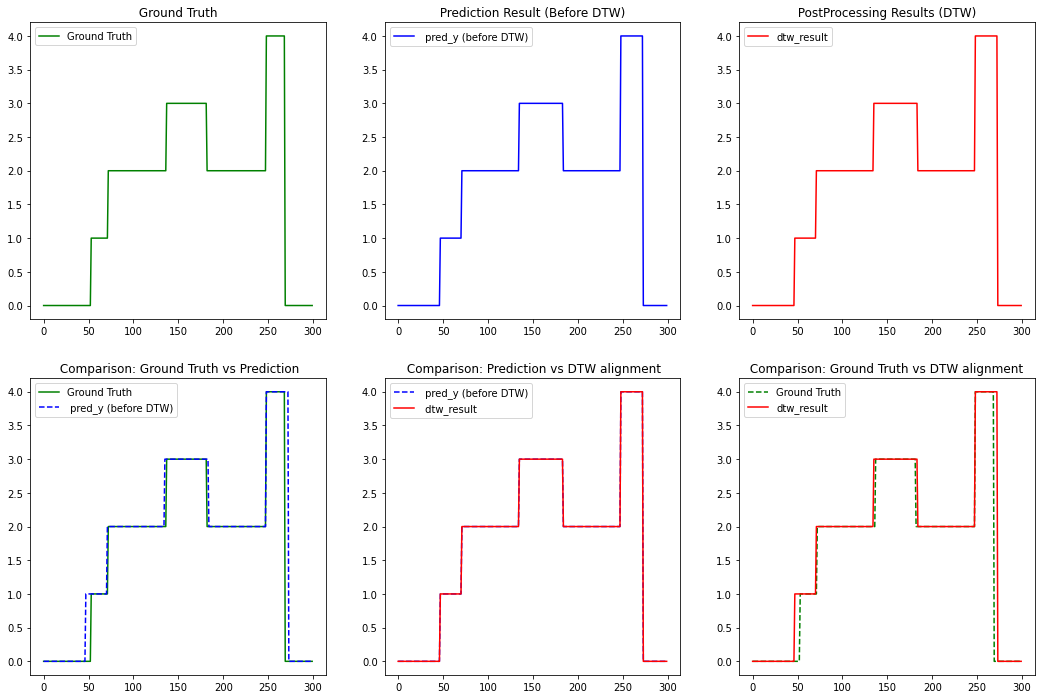

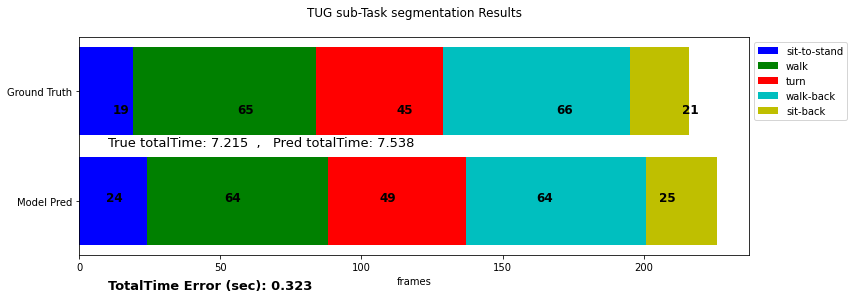

In [7]:


Kfold = True
Kfold_num = 5 
lookback_window = 8




for freq in freqs:   # [0.5, 3.5]
    cutoff_freq = freq 
    selected_LPF = "c{0}o{1}".format(cutoff_freq,lpf_order).replace(".","-")
    clear_output(wait=True)
    
    
    for selected_type in illtyeps: # stroke -3 ,  norm60 -22,  norm20 -1
        mean_datalist = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/{selected_LPF}/{selected_LPF}_mean_{selected_type}.csv".format(selected_LPF=selected_LPF, selected_type=selected_type)
        subjects = np.loadtxt(mean_datalist, delimiter=",", skiprows=1, usecols=0, dtype=str)
        specific_group = sorted(set(subjects)) 
        #--- K fold 
        numOfsubjects = len(specific_group)
        trainFold, testFold = fold_trainNames(subList = specific_group, Kfold_num = Kfold_num)

        for selected_foldNum in range(Kfold_num):
            train_subjects = trainFold[selected_foldNum]
            test_subjects = testFold[selected_foldNum]  
             
            Foldername = "Originact5_lpf_" + selected_LPF
            total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  utils.readLPF_createDataset(specific_group, train_subjects, test_subjects, Foldername, Kfold )
            print("train_x: ", train_x.shape," , train_y: ", train_y.shape)
            print("valid_x: ",valid_x.shape, " , valid_y: ",valid_y.shape)
            print("test_x: ",test_x.shape, "  , test_y: ",test_y.shape)

            clear_output()

            ModelTime =  time.strftime('%Y%m%d-Time_%H-%M', time.localtime(time.time())) 
            MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/temporalCNN_wLabel/KResults/" + selected_LPF + expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience)+"_Kfold"+str(selected_foldNum)+"_"+ ModelTime +  "/Model" 
            print(MODEL_SAVE_FOLDER_PATH)
            if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
                os.makedirs(MODEL_SAVE_FOLDER_PATH)

            model_path = MODEL_SAVE_FOLDER_PATH + "-Batch:"+ str(batch_size) +"-lr:"+ str(learning_rate) +"-p:" +str(patience)+ "_{epoch:04d} -- {loss:.4f}.hdf5"
            cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="loss", verbose=1, save_best_only=True)
            cb_early_stopping = EarlyStopping(monitor="loss", patience=patience)

            clear_output()

            optimizer = tf.optimizers.Adam(learning_rate)

            model = TCN(optimizer)
            model.save(MODEL_SAVE_FOLDER_PATH+"/Origin_TCN_model")
            # hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=2, validation_data= (valid_x, valid_y),   callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
            hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=1, callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
            eval_result = model.evaluate(test_x, test_y,batch_size= batch_size,verbose=1)

            reportd_subjects = open(MODEL_SAVE_FOLDER_PATH + "/" + str(selected_type)+ "_subjectLists_Kfold_" + str(selected_foldNum) + ".txt",'w+t')

            for i in range(Kfold_num): 
                print("\t [", i, "-fold] Train :", trainFold[i], "\n\t\t\t, Test Fold: ", testFold[i], file = reportd_subjects)

            print("selected_foldNum: ", selected_foldNum, file = reportd_subjects)
            print("[Train subjects]\n\t", train_subjects , file =reportd_subjects )
            print("[Test subjects]\n\t", test_subjects , file =reportd_subjects )
            print("======== Class Weight =========", file =reportd_subjects)
            print("\t --> sit,   sit-stand,   walk,   turn,   stand-sit ",class_weight, file =reportd_subjects)
            print('test_loss:',eval_result[0],'- test_acc:',eval_result[1], file =reportd_subjects)
            reportd_subjects.close()   

            print('test_loss:',eval_result[0],'- test_acc:',eval_result[1])
            clear_output()


            fig, loss_ax = plt.subplots()
            acc_ax = loss_ax.twinx()

            loss_ax.plot(hist.history['loss'], 'y', label='train loss')
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('loss')
            loss_ax.legend(loc='upper left')

            acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
            acc_ax.set_ylabel('accuracy')
            acc_ax.legend(loc='lower left')

            plt.savefig(MODEL_SAVE_FOLDER_PATH+"/lr_"+str(learning_rate)+"_patience_"+ str(patience)+"_Loss_"+str(np.round(eval_result[1],4))+".png")
            plt.show()

            clear_output()



            y_pred = model.predict(test_x)
            y_pred_onehot = np.argmax(y_pred, axis=1)

            y_test_argmax = np.argmax(test_y ,axis=1) 
            y_pred_argmax = np.argmax(y_pred ,axis=1)

            y_pred_frames = action_frames(y_pred_argmax, ratio_display= True)
            y_test_frames = action_frames(y_test_argmax,  ratio_display= True)   
            print("--->  # of Each Action Frames  \n\t y_pred: {0}, \n\t y_test: {1}".format(y_pred_frames, y_test_frames))

            clear_output()


            kappa = cohen_kappa_score(y_test_argmax, y_pred_argmax)
            print('Cohens kappa: %f' % kappa)

            print(classification_report(y_test_argmax, y_pred_argmax))
            conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
            print("\n---> Confusion Matrix \n" ,conf_matrix) # sit, sit-stand, walking, turning, stand-sit

            plt.figure(figsize = (15,7) )
            sns.heatmap(conf_matrix, annot=True)
            plt.title("Confusion Matrix")
            plt.savefig(MODEL_SAVE_FOLDER_PATH+"/pred_Confusion_Matrix.png")
            plt.show()

            clear_output()

            test_normal_20 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm20/jek/02/Originact5_lpf_labeled_jek_02.csv"
            test_normal_20_time, test_normal_20_x, test_normal_20_y_onehot = create_testdata(test_normal_20) 
            test_normal_20_y = np.argmax(test_normal_20_y_onehot, axis=1).reshape(-1) # GND one-hot decode

            pred_normal_20_y_onehot = model.predict(test_normal_20_x) 
            pred_normal_20_y = np.argmax(pred_normal_20_y_onehot, axis=1) #  # pred one-hot decode

            title = "normal_20"
            normal_20_alignment, normal_20_results, true_subTask_frame_20, true_totalTime_20, pred_subTask_frame_20, pred_totalTime_20 = post_process_DTW(test_normal_20_time, test_normal_20_y, pred_normal_20_y, answer_y, title = title)

            # --------------- DTW Result Visualization ------------------------ #
            normal_20_alignment.plot(type="threeway")
            plot_postResults(test_normal_20_y, pred_normal_20_y, normal_20_results, title = title)
            norm_20_eval = model.evaluate(test_normal_20_x, test_normal_20_y_onehot, batch_size= batch_size,verbose=2)

            report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_20.txt",'w+t')
            print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names), file = report_dtw)
            print("------------------------------\n", file = report_dtw)
            print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names), file = report_dtw)
            report_dtw.close()

            # # ----------- Visualize in cell
            print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names))
            print("------------------------------\n")
            print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names))


            print(" [True]", true_subTask_frame_20, true_totalTime_20,"\n [Pred]", pred_subTask_frame_20, pred_totalTime_20) 
            barplot_splitResults(pred_subTask_frame_20, true_subTask_frame_20,pred_totalTime_20, true_totalTime_20, title=title)

            clear_output()

            test_normal_30 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm20/jdh/03/Originact5_lpf_labeled_jdh_03.csv"
            test_normal_30_time, test_normal_30_x, test_normal_30_y_onehot = create_testdata(test_normal_30) 
            test_normal_30_y = np.argmax(test_normal_30_y_onehot, axis=1).reshape(-1) # one-hot decode

            pred_normal_30_onehot = model.predict(test_normal_30_x)
            pred_normal_30_y = np.argmax(pred_normal_30_onehot, axis=1)

            title = "normal_30"
            normal_30_alignment, normal_30_results,  true_subTask_frame_30, true_totalTime_30, pred_subTask_frame_30, pred_totalTime_30 = post_process_DTW(test_normal_30_time, test_normal_30_y, pred_normal_30_y, answer_y, title=title)

            # --------------- DTW Result Visualization ------------------------ #
            normal_30_alignment.plot(type="threeway")
            plot_postResults(test_normal_30_y, pred_normal_30_y, normal_30_results, title=title)
            norm_30_eval = model.evaluate(test_normal_30_x, test_normal_30_y_onehot,batch_size= batch_size,verbose=2)

            report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_30.txt",'w+t')
            print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names), file = report_dtw)
            print("------------------------------\n", file = report_dtw)
            print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names), file = report_dtw)
            report_dtw.close()

            # # ----------- Visualize in cell
            print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names))
            print("------------------------------\n")
            print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names))

            print(" [True]", true_subTask_frame_30, true_totalTime_30,"\n [Pred]", pred_subTask_frame_30, pred_totalTime_30) 
            barplot_splitResults(pred_subTask_frame_30, true_subTask_frame_30, pred_totalTime_30,true_totalTime_30, title=title)

            clear_output()

        #     test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2021_02_09 TUG/UMS_TUG/05/Originact5_lpf_labeled_UMS_TUG_05.csv"
            test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm60/LBL_TUG/05/Originact5_lpf_labeled_LBL_TUG_05.csv"
            test_normal_60_time, test_normal_60_x, test_normal_60_y_onehot = create_testdata(test_normal_60) 
            test_normal_60_y = np.argmax(test_normal_60_y_onehot, axis=1).reshape(-1) # one-hot decode


            pred_normal_60_onehot = model.predict(test_normal_60_x)
            pred_normal_60_y = np.argmax(pred_normal_60_onehot, axis=1).reshape(-1) 

            title = "normal_60"
            normal_60_alignment, normal_60_results, true_subTask_frame_60, true_totalTime_60, pred_subTask_frame_60, pred_totalTime_60 = post_process_DTW(test_normal_60_time, test_normal_60_y, pred_normal_60_y, answer_y, title=title)


            # --------------- DTW Result Visualization ------------------------ #
            normal_60_alignment.plot(type="threeway")
            plot_postResults(test_normal_60_y, pred_normal_60_y, normal_60_results, title=title)
            norm_60_eval = model.evaluate(test_normal_60_x, test_normal_60_y_onehot, batch_size= batch_size,verbose=2)

            report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_60.txt",'w+t')
            print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names), file = report_dtw)
            print("------------------------------\n",file = report_dtw)
            print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names), file =   report_dtw)
            report_dtw.close()

            # ----------- Visualize in cell
            print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names))
            print("------------------------------\n")
            print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names))

            print(" [True]", true_subTask_frame_60, true_totalTime_60,"\n [Pred]", pred_subTask_frame_60, pred_totalTime_60) 
            barplot_splitResults(pred_subTask_frame_60, true_subTask_frame_60, pred_totalTime_60, true_totalTime_60, title=title)

            clear_output()

            src = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel/KResults/" + selected_LPF + expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience)+"_Kfold"+str(selected_foldNum)+"_"+ ModelTime 
            dst = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel/KResults/" + selected_LPF + expertFolder +"/" + cw_type +"/"+ str(selected_type) +"_P" +str(patience)+"_Kfold"+str(selected_foldNum)+"_"+ ModelTime  + "_loss-" + str(np.round(eval_result[1],4))
            print(dst)
            os.rename(src, dst)


lookback_window = 8

selected_foldNum = 0
train_subjects = trainFold[selected_foldNum]
test_subjects = testFold[selected_foldNum]  


total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  utils.readLPF_createDataset(specific_group, train_subjects, test_subjects, Kfold )
print("train_x: ", train_x.shape," , train_y: ", train_y.shape)
print("valid_x: ",valid_x.shape, " , valid_y: ",valid_y.shape)
print("test_x: ",test_x.shape, "  , test_y: ",test_y.shape)


### Model Build

from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tcn import TCN

ModelTime =  time.strftime('%Y%m%d-Time_%H-%M', time.localtime(time.time())) +  "/Model" 
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/Results" + expertFolder +"/" + ModelTime

print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.makedirs(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "LookBack- "+ str(lookback_window) +" Origin" + "{epoch:04d} ---- {val_loss: .4f}.hdf5"
patience = 50

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="val_loss", patience=patience)

class_weight = {0:0.303, 1:1.0, 2: 0.144, 3:0.487, 4: 0.7}

batch_size = 512
epochs = 100000
learning_rate = 0.00001

patience = 10



ModelTime =  time.strftime('%Y%m%d-Time_%H-%M', time.localtime(time.time())) +  "/Model" 
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/temporalCNN_wLabel/KResults" + expertFolder +"/P" +str(patience) + "_"+str(selected_type)+"_Kfold"+str(selected_foldNum)+"_"+ ModelTime

print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.makedirs(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "-"+ selected_type +"-lr:"+ str(learning_rate) +"-p:" +str(patience)+ "_{epoch:04d} -- {val_loss:.4f}.hdf5"


cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="loss", patience=patience)

 #Residual block :: https://roadcom.tistory.com/95
def ResBlock(x,filters,kernel_size,dilation_rate):
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate,activation='relu')(x) #first convolution
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate)(r) #Second convolution
    if x.shape[-1]==filters:
        # Shortcut 의 channel 과 main path 의 channel 이 일치할 경우 단순 add 연산만 진행하는 블록 = identity block
        shortcut = x  # identity block 
    else: 
        # Shortcut 의 channel 과 main path 의 channel 이 다를 경우 shortcut path 를 적절히 변환
        # 즉, projection 을 통해 channel 을 맞춰주는 작업이(projection shortcut) 추가되기에 이를 convolution block 이라함
        shortcut=Conv2D(filters,kernel_size=kernel_size,padding='same')(x) 
    o=add([r,shortcut])
    o=Activation('relu')(o) 
    return o
 
 #Sequence Model
def TCN(optimizer='adam'):
    kernel_size = (3,3)
    input_shape =  (lookback_window, 3, 1) # (8,3, 1) = (feature, sliding_window, 1)
    
    inputs=Input(shape=input_shape)
    
    x=ResBlock(x = inputs,filters=32,kernel_size=kernel_size,dilation_rate=1)
    x = Dropout(0.2) (x)
    x=ResBlock(x,filters=32,kernel_size=kernel_size,dilation_rate=2)
    x = Dropout(0.4)(x)
    x=ResBlock(x,filters=16,kernel_size=kernel_size,dilation_rate=4)
    
    x=Flatten()(x)
    x=Dense(numActions, activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
         
    model.summary()
        
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     
    return model


optimizer = tf.optimizers.Adam(learning_rate)

model = TCN(optimizer)
model.save(MODEL_SAVE_FOLDER_PATH+"/Origin_TCN_model")
# hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=2, validation_data= (valid_x, valid_y),   callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=1, callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
eval_result = model.evaluate(test_x, test_y,batch_size= batch_size,verbose=1)

print('test_loss:',eval_result[0],'- test_acc:',eval_result[1])

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.savefig(MODEL_SAVE_FOLDER_PATH+"/lr_"+str(learning_rate)+"_patience_"+ str(patience)+"_Loss_"+str(np.round(eval_result[1],4))+".png")
plt.show()


def action_frames(y_pred_argmax, ratio_display = False):
    action_label =  {"sit": 0, "sit-stand": 1,  "walk": 2, "turn": 3,  "stand-sit": 4}
    action_cnt =  {"total_frames": 0,"sit": 0, "sit-stand": 0,  "walk": 0, "turn": 0,"stand-sit": 0}

    for i in range(len(y_pred_argmax)):
        action_cnt["total_frames"] +=1
        if y_pred_argmax[i] == action_label["sit"]:
            action_cnt["sit"] +=1
            
        elif y_pred_argmax[i] == action_label["sit-stand"]:
            action_cnt["sit-stand"] +=1
            
        elif y_pred_argmax[i] == action_label["walk"]:
            action_cnt["walk"] +=1
            
        elif y_pred_argmax[i] == action_label["turn"]:
            action_cnt["turn"] +=1
        
            
        elif y_pred_argmax[i] == action_label["stand-sit"]:
            action_cnt["stand-sit"] +=1
        
    if ratio_display:     
        print("[ Action Ratio ]")
        print("\t [ 0 - Sit] ratio of sit: ",  action_cnt["sit"]/action_cnt["total_frames"] )
        print("\t [ 1 - sit-stand] ratio of sit-stand: ",  action_cnt["sit-stand"]/action_cnt["total_frames"])
        print("\t [ 2 - walk] ratio of walk: ",  action_cnt["walk"]/action_cnt["total_frames"])
        print("\t [ 3 - turn] ratio of turn: ",  action_cnt["turn"]/action_cnt["total_frames"])
        print("\t [ 4 - stand-sit] ratio of stand-sit: ",  action_cnt["stand-sit"]/action_cnt["total_frames"])
    return action_cnt
    
    
    
y_pred = model.predict(test_x)
y_pred_onehot = np.argmax(y_pred, axis=1)
print(y_pred.shape)
print(y_pred[200] ,"===> onehot: ", y_pred_onehot[200])

y_test_argmax = np.argmax(test_y ,axis=1) 
y_pred_argmax = np.argmax(y_pred ,axis=1)
print(y_test_argmax.shape, y_pred_argmax.shape)


y_pred_frames = action_frames(y_pred_argmax, ratio_display= True)
y_test_frames = action_frames(y_test_argmax,  ratio_display= True)   

print("--->  # of Each Action Frames  \n\t y_pred: {0}, \n\t y_test: {1}".format(y_pred_frames, y_test_frames))

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


kappa = cohen_kappa_score(y_test_argmax, y_pred_argmax)
print('Cohens kappa: %f' % kappa)

print(classification_report(y_test_argmax, y_pred_argmax))
conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
print("\n---> Confusion Matrix \n" ,conf_matrix) # sit, sit-stand, walking, turning, stand-sit

plt.figure(figsize = (15,7) )
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.savefig(MODEL_SAVE_FOLDER_PATH+"/pred_Confusion_Matrix.png")
plt.show()

## POST processing (DTW) 

from dtw import dtw
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


act_dict = {"sit":0, "sit-to-stand":1, "walk": 2, "turn": 3, "stand-to-sit":4}
answer_y = [act_dict["sit"], act_dict["sit-to-stand"], act_dict["walk"], act_dict["turn"], act_dict["walk"], act_dict["stand-to-sit"], act_dict["sit"] ]
target_names = ["sit", "sit-to-stand", "walk", "turn", "stand-to-sit"]


def post_process_DTW(time_sec, test_y, pred_y, answer_y, title = "normal_20"):
    dtw_index ={"walk":4, "stand-to-sit": 5, "sit": 6}
    dtw_alignment  = dtw(pred_y,answer_y, keep_internals=True)
    
    pred_subTask_sec = np.zeros(5)
    true_subTask_sec = np.zeros(5)
    
    pred_subTask_frame = np.zeros(5, np.uint64)
    true_subTask_frame = np.zeros(5, np.uint64)

    report_time= open(MODEL_SAVE_FOLDER_PATH + "/Report_frameSplit_Results_" + str( title)  +".txt",'w+t')
    # ----------- Time split ... Frame Index
    pred_splitFrame =  np.where( np.abs(dtw_alignment.index2[1:]-dtw_alignment.index2[:-1] ) > 0)[0] 
    true_splitFrame = np.where( np.abs(test_y[1:]-test_y[:-1] ) > 0)[0] + 8 # lookback_window

    print("\npred_splitFrame: {0} \n--> true_splitFrame: {1}".format(pred_splitFrame,true_splitFrame), file = report_time)
    
    for i in range(5):
        pred_subTask_sec[i] = time_sec[ pred_splitFrame[i+1]] - time_sec[ pred_splitFrame[i]]  # sit ~ sit-to-stand (sit-to-stand)
        true_subTask_sec[i] = time_sec[ true_splitFrame[i+1]] - time_sec[ true_splitFrame[i]]     
        
        pred_subTask_frame[i] = pred_splitFrame[i+1] - pred_splitFrame[i]
        true_subTask_frame[i] = true_splitFrame[i+1] - true_splitFrame[i]
    print("\npred subTask frame: {0} \n--> true subTask frame: {1}".format(pred_subTask_frame , true_subTask_frame), file = report_time)
    

  
        
    # ---- Total Time
    pred_totalTime = np.sum(pred_subTask_sec)
    true_totalTime = np.sum(true_subTask_sec)
    print("\nPred SubTask Time: ", pred_subTask_sec, "\t\t Pred Total Time", pred_totalTime, file = report_time)
    print("--> True SubTask Time: ", true_subTask_sec, "\t\t True Total Time", true_totalTime, file = report_time)
 
    #----------- Error---------
    print("\n\n[SubTask Time Error] true - pred (sec): ", np.abs(np.round(true_subTask_sec - pred_subTask_sec,4)), file = report_time)
    print("[Total Time Error] true - pred (sec): " , np.abs(np.round(true_totalTime - pred_totalTime,4)) , file = report_time)
    report_time.close()
    
    # ------------ Index 4,5,6 --> 2,4,0 으로 변경 
    results =[]
    for elements in dtw_alignment.index2:
        if elements == dtw_index["walk"]: 
            elements = act_dict["walk"]
        elif elements == dtw_index["stand-to-sit"]:  
            elements = act_dict["stand-to-sit"]
        elif elements == dtw_index["sit"]:  
            elements =  act_dict["sit"]     
        results.append(elements)


    # 간혹.. dtw 결과가 1개 더 많이 나올 때 있음.. 걍 뒤에 하나 지워버려..
    if len(dtw_alignment.index2) > len(pred_y):
        new_result = results[:-1]
    else:
        new_result = results
        
    return dtw_alignment, new_result, true_subTask_frame, true_totalTime, pred_subTask_frame, pred_totalTime


def plot_postResults(answer_y, pred_y, results, title="dtw"):
    fig = plt.figure(figsize=(18,12))
    
    Gnd_fig = fig.add_subplot(2,3,1)
    Gnd_fig.set_title(" Ground Truth ")
    Gnd_fig.plot(answer_y, "g", label = "Ground Truth")
    plt.legend()
    
    pred_fig = fig.add_subplot(2,3,2)
    pred_fig.set_title(" Prediction Result (Before DTW) ")
    pred_fig.plot(pred_y, "b", label=" pred_y (before DTW)")
    plt.legend()
    
    dtw_fig = fig.add_subplot(2,3,3)
    dtw_fig.set_title(" PostProcessing Results (DTW) ")
    dtw_fig.plot(results, "r",  label="dtw_result")
    plt.legend()
    
    gnd_pred_fig = fig.add_subplot(2,3,4)
    gnd_pred_fig.set_title(" Comparison: Ground Truth vs Prediction")
    gnd_pred_fig.plot(answer_y, "g", label="Ground Truth") # linewidth=3
    gnd_pred_fig.plot(pred_y, "b--", label=" pred_y (before DTW)")
    plt.legend()
    
    pred_dtw_fig = fig.add_subplot(2,3,5)
    pred_dtw_fig.set_title(" Comparison: Prediction vs DTW alignment")
    pred_dtw_fig.plot(pred_y, "b--", label=" pred_y (before DTW)") # linewidth=3
    pred_dtw_fig.plot(results, "r", label=" dtw_result")
    plt.legend()
    
    gnd_dtw_fig = fig.add_subplot(2,3,6)
    gnd_dtw_fig.set_title(" Comparison: Ground Truth vs DTW alignment ")
    gnd_dtw_fig.plot(answer_y, "g--", label="Ground Truth")
    gnd_dtw_fig.plot(results, "r", label="dtw_result")  # linewidth=3
    
    plt.legend()
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/DTW_Comparison_" + title  + ".png")
    
    
    
def create_testdata(pelvis_csv, lookback_window = 8):
    test_x = np.zeros((0, utils.lookback_window,  utils.numPelvis,1 ))
    test_y = np.zeros((0,  utils.numActions)) 
   
    timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  =  utils.getLPF_PelvisData(pelvis_csv)  # raw                 
    pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
    actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
    blockTime, blockPelvis, blockLable =  utils.sliding_window(timstamp_ms, pelvisData, actionData)
    test_x = np.append(test_x, blockPelvis, axis = 0 )
    test_y = np.append(test_y, blockLable, axis = 0 )    

    return blockTime, test_x, test_y


def barplot_splitResults(pred_subTask_frame, true_subTask_frame, pred_totalTime, true_totalTime, title= "normal_20"):
    subTask_label = ['sit-to-stand', 'walk', 'turn', 'walk-back', 'sit-back']
    actIndex = np.arange(len( ["Pred", "Truth"]))
    color = ['b','g','r','c','y']
    
        
    fig = plt.figure(figsize=(12,4))
    plt.title('TUG sub-Task segmentation Results\n', loc='center')
    plt.xlabel('frames')
    plt.yticks(actIndex,  ["Model Pred", "Ground Truth"])
    plt.text(10, 0.5, "True totalTime: " + str(np.round(true_totalTime,4)) + "  ,   Pred totalTime: " + str(np.round(pred_totalTime,4)), fontsize=13)
    plt.text(10,-0.8, "TotalTime Error (sec): " + str(np.round(np.abs(true_totalTime-pred_totalTime),4)), fontsize=13, fontweight='bold')
    
    

    for i in range(len(color)):
        rects = plt.barh(actIndex,  [pred_subTask_frame[i] , true_subTask_frame[i]] , color = color[i], left = [ np.sum(np.sum(pred_subTask_frame[:i])),  np.sum(np.sum(true_subTask_frame[:i]))] )
 
        for j, rect in enumerate(rects):
            if j is 0:  # --- pred
                h1 = rect.get_height()
                w1 = rect.get_width()
                plt.text(rect.get_x() + rect.get_width() / 2., h1 / 1., "%d" % true_subTask_frame[i], color="k", fontsize=12, fontweight="bold")         

            else:  # -- true 
                h2 = rect.get_height()
                w2 = rect.get_width()
                plt.text(rect.get_x() + w2/ 2., (h2-h1) / 1.,"%d" % pred_subTask_frame[i], color="k", fontsize=12, fontweight="bold")

        

    plt.legend(subTask_label,  bbox_to_anchor=([1, 1, 0, 0]))                         
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/BarGragh_FrameSplit_" + title  + ".png")
                         
            


### 정상인 20대, 30대, 60대 

test_normal_20 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm20/jek/02/Originact5_lpf_labeled_jek_02.csv"
test_normal_20_time, test_normal_20_x, test_normal_20_y_onehot = create_testdata(test_normal_20) 
test_normal_20_y = np.argmax(test_normal_20_y_onehot, axis=1).reshape(-1) # GND one-hot decode

pred_normal_20_y_onehot = model.predict(test_normal_20_x) 
pred_normal_20_y = np.argmax(pred_normal_20_y_onehot, axis=1) #  # pred one-hot decode

title = "normal_20"
normal_20_alignment, normal_20_results, true_subTask_frame_20, true_totalTime_20, pred_subTask_frame_20, pred_totalTime_20 = post_process_DTW(test_normal_20_time, test_normal_20_y, pred_normal_20_y, answer_y, title = title)

# --------------- DTW Result Visualization ------------------------ #
normal_20_alignment.plot(type="threeway")
plot_postResults(test_normal_20_y, pred_normal_20_y, normal_20_results, title = title)
norm_20_eval = model.evaluate(test_normal_20_x, test_normal_20_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_20.txt",'w+t')
print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names))


print(" [True]", true_subTask_frame_20, true_totalTime_20,"\n [Pred]", pred_subTask_frame_20, pred_totalTime_20) 
barplot_splitResults(pred_subTask_frame_20, true_subTask_frame_20,pred_totalTime_20, true_totalTime_20, title=title)

test_normal_30 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm20/jdh/03/Originact5_lpf_labeled_jdh_03.csv"
test_normal_30_time, test_normal_30_x, test_normal_30_y_onehot = create_testdata(test_normal_30) 
test_normal_30_y = np.argmax(test_normal_30_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_normal_30_onehot = model.predict(test_normal_30_x)
pred_normal_30_y = np.argmax(pred_normal_30_onehot, axis=1)

title = "normal_30"
normal_30_alignment, normal_30_results,  true_subTask_frame_30, true_totalTime_30, pred_subTask_frame_30, pred_totalTime_30 = post_process_DTW(test_normal_30_time, test_normal_30_y, pred_normal_30_y, answer_y, title=title)

# --------------- DTW Result Visualization ------------------------ #
normal_30_alignment.plot(type="threeway")
plot_postResults(test_normal_30_y, pred_normal_30_y, normal_30_results, title=title)
norm_30_eval = model.evaluate(test_normal_30_x, test_normal_30_y_onehot,batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_30.txt",'w+t')
print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names))

print(" [True]", true_subTask_frame_30, true_totalTime_30,"\n [Pred]", pred_subTask_frame_30, pred_totalTime_30) 
barplot_splitResults(pred_subTask_frame_30, true_subTask_frame_30, pred_totalTime_30,true_totalTime_30, title=title)

# test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2021_02_09 TUG/UMS_TUG/05/Originact5_lpf_labeled_UMS_TUG_05.csv"
test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm60/LBL_TUG/05/Originact5_lpf_labeled_LBL_TUG_05.csv"
test_normal_60_time, test_normal_60_x, test_normal_60_y_onehot = create_testdata(test_normal_60) 
test_normal_60_y = np.argmax(test_normal_60_y_onehot, axis=1).reshape(-1) # one-hot decode


pred_normal_60_onehot = model.predict(test_normal_60_x)
pred_normal_60_y = np.argmax(pred_normal_60_onehot, axis=1).reshape(-1) 

title = "normal_60"
normal_60_alignment, normal_60_results, true_subTask_frame_60, true_totalTime_60, pred_subTask_frame_60, pred_totalTime_60 = post_process_DTW(test_normal_60_time, test_normal_60_y, pred_normal_60_y, answer_y, title=title)


# --------------- DTW Result Visualization ------------------------ #
normal_60_alignment.plot(type="threeway")
plot_postResults(test_normal_60_y, pred_normal_60_y, normal_60_results, title=title)
norm_60_eval = model.evaluate(test_normal_60_x, test_normal_60_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_60.txt",'w+t')
print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names), file = report_dtw)
print("------------------------------\n",file = report_dtw)
print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names), file =   report_dtw)
report_dtw.close()

# ----------- Visualize in cell
print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names))

print(" [True]", true_subTask_frame_60, true_totalTime_60,"\n [Pred]", pred_subTask_frame_60, pred_totalTime_60) 
barplot_splitResults(pred_subTask_frame_60, true_subTask_frame_60, pred_totalTime_60, true_totalTime_60, title=title)

###  Stroke -- 보조필요 없는 수준의 편마비, 케인/지팡이 사용,  모방 보행

test_stroke_1 =  "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/stroke/JDW_tug/02/Originact5_lpf_labeled_JDW_tug_02.csv"
test_normal_stroke_time, test_stroke_1_x, test_stroke_1_y_onehot = create_testdata(test_stroke_1)  
test_stroke_1_y = np.argmax(test_stroke_1_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_stroke_1_one_hot = model.predict(test_stroke_1_x)
pred_stroke_1_y = np.argmax(pred_stroke_1_one_hot, axis=1)

title="stroke_1"
stroke_1_alignment, stroke_1_results, true_subTask_frame_stroke, true_totalTime_stroke, pred_subTask_frame_stroke, pred_totalTime_stroke = post_process_DTW(test_normal_stroke_time, test_stroke_1_y, pred_stroke_1_y, answer_y,  title=title)


# --------------- DTW Result Visualization ------------------------ #
stroke_1_alignment.plot(type="threeway")
plot_postResults(test_stroke_1_y, pred_stroke_1_y, stroke_1_results, title=title)
stroke_1_eval = model.evaluate(test_stroke_1_x, test_stroke_1_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_stroke_1.txt",'w+t')
print("[Before DTW] Before DTW stroke_1 \n", classification_report(test_stroke_1_y, pred_stroke_1_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After DTW stroke_1 \n", classification_report(test_stroke_1_y, stroke_1_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before DTW stroke_1 \n", classification_report(test_stroke_1_y, pred_stroke_1_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After DTW stroke_1 \n", classification_report(test_stroke_1_y, stroke_1_results, target_names=target_names))

print(" [True]", true_subTask_frame_stroke, true_totalTime_stroke,"\n [Pred]", pred_subTask_frame_stroke, pred_totalTime_stroke) 
barplot_splitResults(pred_subTask_frame_stroke, true_subTask_frame_stroke, pred_totalTime_stroke, true_totalTime_stroke, title=title)

test_stroke_tool = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/stroke/KNG_TUG/03/Originact5_lpf_labeled_KNG_TUG_03.csv"
test_stroke_tool_time, test_stroke_tool_x, test_stroke_tool_y_onehot = create_testdata(test_stroke_tool) 
test_stroke_tool_y = np.argmax(test_stroke_tool_y_onehot, axis=1).reshape(-1) #one-hot decode

pred_stroke_tool_onehot = model.predict(test_stroke_tool_x)
pred_stroke_tool_y = np.argmax(pred_stroke_tool_onehot, axis=1)

title = "stroke_tool"
stroke_tool_alignment, stroke_tool_results, true_subTask_frame_stroke_tool, true_totalTime_stroke_tool, pred_subTask_frame_stroke_tool, pred_totalTime_stroke_tool = post_process_DTW(test_stroke_tool_time, test_stroke_tool_y, pred_stroke_tool_y, answer_y, title=title)


# --------------- DTW Result Visualization ------------------------ #
stroke_tool_alignment.plot(type="threeway")
plot_postResults(test_stroke_tool_y, pred_stroke_tool_y, stroke_tool_results, title=title)
stroke_tool_eval = model.evaluate(test_stroke_tool_x, test_stroke_tool_y_onehot,batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_stroke_tool.txt",'w+t')
print("[Before DTW] Before DTW stroke_tool \n", classification_report(test_stroke_tool_y, pred_stroke_tool_y, target_names=target_names), file = report_dtw)
print("------------------------------\n ", file = report_dtw)
print("[After DTW] After DTW stroke_tool \n", classification_report(test_stroke_tool_y, stroke_tool_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before DTW stroke_tool \n", classification_report(test_stroke_tool_y, pred_stroke_tool_y, target_names=target_names))
print("------------------------------\n ")
print("[After DTW] After DTW stroke_tool \n", classification_report(test_stroke_tool_y, stroke_tool_results, target_names=target_names))

print(" [True]", true_subTask_frame_stroke_tool, true_totalTime_stroke_tool,"\n [Pred]", pred_subTask_frame_stroke_tool, pred_totalTime_stroke_tool) 
barplot_splitResults(pred_subTask_frame_stroke_tool, true_subTask_frame_stroke_tool, pred_totalTime_stroke_tool, true_totalTime_stroke_tool, title=title)